In [1]:
%cd ~/repositories/degen_discovery/simple_problems/

/Users/lucas/repositories/degen_discovery/simple_problems


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
pwd

'/Users/lucas/repositories/degen_discovery/simple_problems'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoperon.sklearn import SymbolicRegressor
import multiprocessing
import csv
from sklearn.metrics import r2_score
import string
import sys
import sympy
import scipy
import esr.generation.generator

import jax
import jax.numpy as jnp
from tqdm import tqdm as tq

sys.path.append("/Users/lucas/repositories/degen_discovery/package/")

from sr_functions import *
from training_loop_flattening import *



In [4]:
pwd

'/Users/lucas/repositories/degen_discovery/simple_problems'

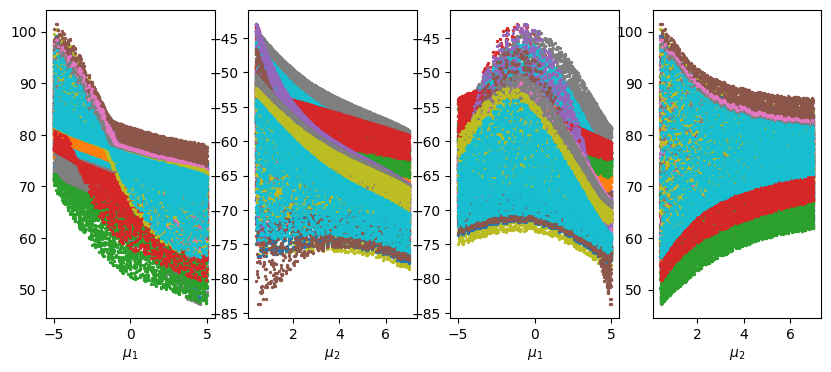

(20, 5000, 2, 2)
(20, 5000, 2)


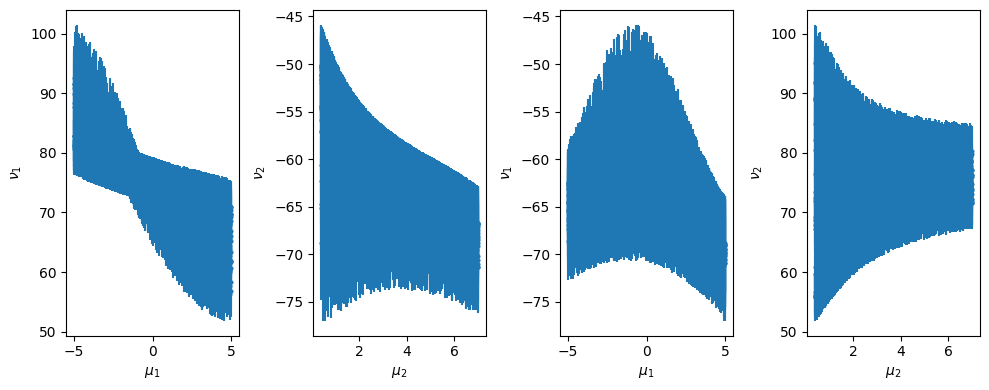

In [5]:
datafile = np.load("flattened_coords_little_sigma.npz")


X = datafile["theta"] #[randidx, :] #+ np.array([5.0, 0.0])
ensemble_weights = datafile["ensemble_weights"]
# incorporate a mask for nonlinear regime of Var param
mask = np.ones(X.shape[0]).astype(bool)

num_tot = mask.sum()
num_samps = 4000

skip = 10
finish = 10000

np.random.seed(44)

randidx = np.random.choice(num_tot, size=num_samps, replace=False)

X = datafile["theta"]

# train-test split
halfx = X.shape[0] // 2


Jbar = datafile["Jacobians"]
ensemble_Fs = np.array([f for f in datafile["F_ensemble"]])
ys = np.array([r for r in  datafile['eta_ensemble']])
dys = np.array([r for r in  datafile['Jbar_ensemble']])
ensemble_weights = datafile['ensemble_weights']

num_nets = ensemble_Fs.shape[0]

fig, axs = plt.subplots(1, 4, figsize=(10,4))

for i in range(0,num_nets):
    y = ys[i]
    axs[0].scatter(X[:,0], y[:, 0], label='', s=2)
    axs[0].set_xlabel(r"$\mu_1$")

    axs[1].scatter(X[:,1], y[:, 1], label='', s=2)
    axs[1].set_xlabel(r"$\mu_2$")

    axs[2].scatter(X[:,0], y[:, 1], label='', s=2)
    axs[2].set_xlabel(r"$\mu_1$")

    axs[3].scatter(X[:,1], y[:, 0], label='', s=2)
    axs[3].set_xlabel(r"$\mu_2$")


plt.show()

print(dys.shape)
print(ys.shape)

# weighted average and std of y values
y = np.average(ys, axis=0, weights=ensemble_weights) 
y_std = weighted_std(ys, weights=ensemble_weights, axis=0)



# mask out std = 0
msk = (y_std[:, 0] > 0)

y = y[msk]
y_std = y_std[msk]

ys = np.array([_y[msk] for _y in ys])


dy = np.average(dys, axis=0, weights=ensemble_weights)[msk]
dys = np.array([j[msk] for j in dys])

Jbar = dy.copy()

X = X[msk]
Fs = np.array([f[msk] for f in ensemble_Fs])
ensemble_Fs = Fs.copy()

Fs = np.average(Fs, axis=0, weights=ensemble_weights)
#ensemble_Fs = np.array([f[mask][randidx, :] for f in datafile["F_ensemble"]])


# plot the mean of the summary cloud with error bars

fig, axs = plt.subplots(1, 4, figsize=(10,4))
axs[0].errorbar(X[:,0], y[:, 0], yerr=y_std[:, 0], label='', fmt='o', markersize=2)
axs[0].set_xlabel(r"$\mu_1$")
axs[0].set_ylabel(r"$\nu_1$")

axs[1].errorbar(X[:,1], y[:, 1], yerr=y_std[:, 1], label='', fmt='o', markersize=2)
#plt.scatter(X[:, 1], X[:, 0]**2 + X[:, 1], c='k')
axs[1].set_xlabel(r"$\mu_2$")
axs[1].set_ylabel(r"$\nu_2$")

axs[2].errorbar(X[:,0], y[:, 1], yerr=y_std[:, 1], label='', fmt='o', markersize=2)
#plt.scatter(X[:, 0], X[:, 0]**2 + X[:, 1], c='k')
axs[2].set_xlabel(r"$\mu_1$")
axs[2].set_ylabel(r"$\nu_1$")

axs[3].errorbar(X[:,1], y[:, 0], yerr=y_std[:, 0], label='', fmt='o', markersize=2)
#plt.scatter(X[:, 1], X[:, 0]**2 + X[:, 1], c='k')
axs[3].set_xlabel(r"$\mu_2$")
axs[3].set_ylabel(r"$\nu_2$")
plt.tight_layout()
plt.show()




In [6]:
ys.shape

In [7]:
msk.sum()

Array(5000, dtype=int32)

In [8]:
def flatten_with_numerical_jacobian(J_eta, F):
    Jeta_inv = jnp.linalg.pinv(J_eta)
    Q = Jeta_inv @ F @ Jeta_inv.T
    return Q

jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)

Array([[[ 1.1865516 , -0.02611614],
        [-0.02611614,  1.0865988 ]],

       [[ 0.8849953 ,  0.08412596],
        [ 0.08412598,  0.88753366]],

       [[ 1.5344251 ,  0.04764963],
        [ 0.04764963,  1.1616881 ]],

       ...,

       [[ 1.1312268 ,  0.0506563 ],
        [ 0.05065631,  0.9672293 ]],

       [[ 1.4347225 , -0.01075018],
        [-0.01075016,  1.2318609 ]],

       [[ 0.96270615, -0.05286629],
        [-0.05286629,  0.95384467]]], dtype=float32)

In [9]:
jax.vmap(flatten_with_numerical_jacobian)(dy, Fs).mean(0)

Array([[1.1501666, 0.0227959],
       [0.0227959, 1.1202155]], dtype=float32)

In [10]:
datafile['norm_factor']

array(1.)

In [11]:
Fs, dy

(array([[[30.164968  , -0.15334047],
         [-0.15334047, 19.722155  ]],
 
        [[ 6.666256  ,  0.0426996 ],
         [ 0.0426996 ,  6.068211  ]],
 
        [[32.35139   , -0.07231773],
         [-0.07231773, 20.10925   ]],
 
        ...,
 
        [[31.392336  ,  0.49826732],
         [ 0.49826732, 18.853405  ]],
 
        [[34.747017  , -0.41590577],
         [-0.41590577, 21.877455  ]],
 
        [[ 8.851296  ,  0.2718984 ],
         [ 0.2718984 ,  7.2493443 ]]], dtype=float32),
 array([[[-4.6888313 , -2.0533466 ],
         [ 1.5258387 , -3.9141943 ]],
 
        [[-1.4020568 ,  2.4926643 ],
         [-2.273814  , -1.099072  ]],
 
        [[-4.592613  ,  0.3446972 ],
         [-0.09703622, -4.1551    ]],
 
        ...,
 
        [[-0.62512183,  5.6895924 ],
         [-4.0674973 , -0.2203743 ]],
 
        [[-4.6590385 , -1.751598  ],
         [ 1.3136373 , -3.9571621 ]],
 
        [[-2.523729  , -1.8342177 ],
         [ 1.4502177 , -2.2614007 ]]], dtype=float32))

Text(0, 0.5, '$\\langle\\eta_{0,j}\\rangle$')

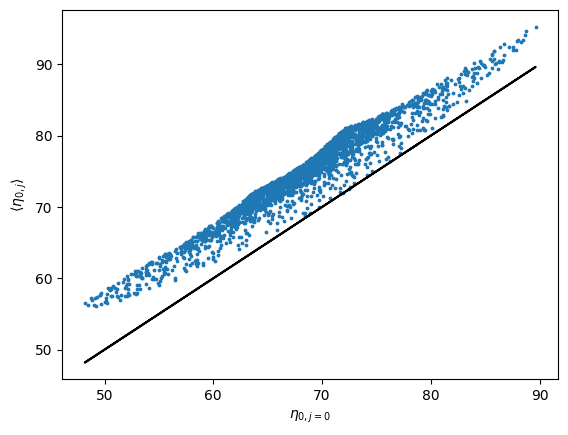

In [12]:
plt.scatter(ys[0, ::2, 0], np.average(ys[1:, ::2, 0], axis=0, \
                            weights=(ensemble_weights[1:])), s=3) 

plt.plot(ys[0, ::2, 0],ys[0, ::2, 0], c='k')
plt.xlabel(r"$\eta_{0,j=0}$")
plt.ylabel(r"$\langle\eta_{0,j}\rangle$")

In [13]:
ensemble_Fs.shape, ys.shape

In [14]:
[k for k in datafile.keys()]

['theta',
 'eta',
 'Jacobians',
 'deltaJ',
 'delta_invJ',
 'meanF',
 'dFs',
 'F_ensemble',
 'norm_factor',
 'ensemble_weights',
 'eta_ensemble',
 'Jbar_ensemble']

(array([  566.,   982.,  3034.,  7122.,  6440., 13712., 14245., 27224.,
        21950.,  4725.]),
 array([-4.10254574, -3.51728964, -2.93203378, -2.34677768, -1.76152182,
        -1.17626572, -0.5910098 , -0.00575379,  0.57950222,  1.16475821,
         1.75001419]),
 <BarContainer object of 10 artists>)

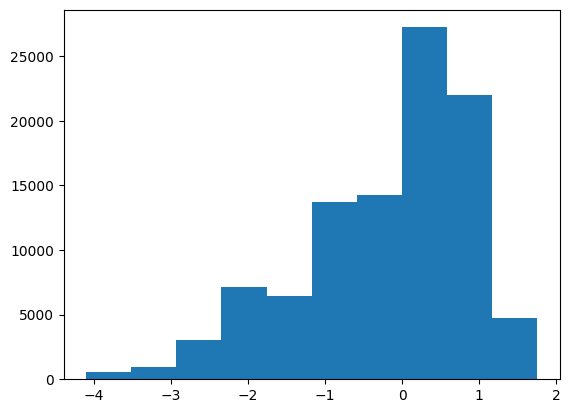

In [15]:
plt.hist(((ys - y) / y_std)[:, :, 0].flatten())

In [16]:
y_std.min()

Array(2.488712, dtype=float32)

(array([  263.,  2714., 13222.,  8481., 22605., 18840., 10151., 13372.,
         5846.,  4506.]),
 array([-2.57961059, -2.06750822, -1.55540574, -1.04330325, -0.53120083,
        -0.0190984 ,  0.49300402,  1.00510645,  1.51720893,  2.02931142,
         2.54141378]),
 <BarContainer object of 10 artists>)

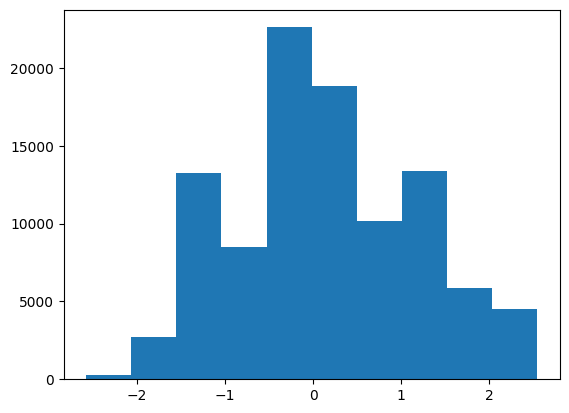

In [17]:
plt.hist(((ys - y) / (y_std))[:, :, 1].flatten())

In [18]:
ys.std(0), y_std

(array([[6.7185397, 2.7847292],
        [3.8335521, 4.2113357],
        [5.6170416, 3.1753628],
        ...,
        [3.8614762, 5.081633 ],
        [6.540727 , 2.8097317],
        [5.1315174, 2.8314266]], dtype=float32),
 Array([[5.593397 , 2.7824147],
        [3.614451 , 4.1955314],
        [4.7518806, 3.1055791],
        ...,
        [3.700913 , 5.0493736],
        [5.457596 , 2.797749 ],
        [4.538121 , 2.7748024]], dtype=float32))

In [19]:
# Some parameters for operon
# parent_dir = 'ensemble_flattening_extreme_Sigma4_1_nd50/' 

parent_dir = 'ensemble_flattening_gauss_little_sigma/' 



allowed_symbols = 'add,mul,pow,constant,variable,exp,logabs' # logabs exp sqrt square
epsilon = 1e-3
max_length = 20 #25 #25 # 25
max_depth = 10 # 6
time_limit = 60 * 4 # s
objectives=['rmse', 'length']#['rmse', 'length']
max_evaluations=1e8
generations=1e8



In [ ]:


if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

n_components = 2


for i in range(n_components):

    out_dir = parent_dir + "component_%d"%(i+1)
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
        
    reg = SymbolicRegressor(
                allowed_symbols=allowed_symbols,
                offspring_generator='basic',
                optimizer_iterations=1000,
                max_length=max_length,
                max_depth=max_depth,
                initialization_method='btc',
                n_threads=multiprocessing.cpu_count(),
                objectives = objectives,
                epsilon = epsilon,
                random_state=None,
                reinserter='keep-best',
                max_evaluations=int(max_evaluations),
                symbolic_mode=False,
                time_limit=int(time_limit),
                generations=int(generations),
                add_model_scale_term           = True,
                add_model_intercept_term       = True,

               # uncertainty=y_std[:, i],
    )
    halfx = X.shape[0] // 2

    Xfit = X[:halfx]
    yfit = y[:halfx, i]

    print("X train shape", Xfit.shape, "y train shape", yfit.shape)

    print('Fitting')
    reg.fit(Xfit, yfit)
    print('Done')
    print(reg.get_model_string(reg.model_, 2))
    print(reg.stats_)


    # Save Pareto front
    with open(f'{out_dir}/pareto.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        
        print(f'Outputting {len(reg.pareto_front_)} individuals on Pareto front')
        
        for i in range(len(reg.pareto_front_)):
            writer.writerow([reg.pareto_front_[i]['tree'].Length,
                            reg.pareto_front_[i]['mean_squared_error'],
                            reg.pareto_front_[i]['model'],
                            ])
            
    # Save population
    print(f'Outputting {len(reg.individuals_)} individuals in population')
    with open(f'{out_dir}/final_population.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        for ind in reg.individuals_[:reg.population_size]:
            tree = ind.Genotype
            
            # Get name but block printing to sys.stderr
            sys.stderr = open(os.devnull, 'w')
            s = reg.get_model_string(ind.Genotype, 10)
            sys.stderr = sys.__stderr__
            
            y_pred = reg.evaluate_model(tree, Xfit)
            mse = np.mean((yfit - y_pred)**2)
            
            writer.writerow([tree.Length,
                            mse,
                            s
                            ])

X train shape (2500, 2) y train shape (2500,)
Fitting
Done
(0.00 + (1.00 * ((((((0.95 * X1) + (-6.93)) * (exp(((-0.54) * X2)) + (0.01 * X1))) + (0.12 * X2)) * (exp(((-0.31) * X1)) + (1.23 * X1))) + (74.61 + ((-1.47) * X1)))))
{'model_length': 19, 'model_complexity': 33, 'generations': 235, 'evaluation_count': 0, 'residual_evaluations': 5017734, 'jacobian_evaluations': 4131693, 'random_state': 902297830726557897}
Outputting 17 individuals on Pareto front
Outputting 2000 individuals in population
X train shape (2500, 2) y train shape (2500,)
Fitting
Done
((-0.02) + (1.00 * (((((exp(((-0.19) * X1)) + (0.24 * X1)) * (-51.59)) + ((-31.42) * X2)) * ((0.02 * X2) ^ (0.11 * X2))) + (exp(((-0.43) * X1)) + (0.76 * X1)))))
{'model_length': 17, 'model_complexity': 31, 'generations': 290, 'evaluation_count': 0, 'residual_evaluations': 5129164, 'jacobian_evaluations': 4056872, 'random_state': 10353060186575450955}
Outputting 17 individuals on Pareto front
Outputting 2000 individuals in population


633it [03:05,  3.41it/s]
601it [02:30,  4.00it/s]
<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:14: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:14: SyntaxWarning: invalid escape sequence '\ '
/var/folders/pg/xm7nmkzn0tq26tlbl6skh5080000gp/T/ipykernel_73574/3348899996.py:11: SyntaxWarning: invalid escape sequence '\ '
  outs += "\\textbf{COMPONENT %d}\n \n"%(idx+1) + "\\begin{tabular}{l|l} log loss & Equation \\\ \n \\hline \n"
/var/folders/pg/xm7nmkzn0tq26tlbl6skh5080000gp/T/ipykernel_73574/3348899996.py:14: SyntaxWarning: invalid escape sequence '\ '
  outs += "%.2f"%(both_comp_logL[idx][i]) + " & " +  t + " \\\ \n"
<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:14: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:14: SyntaxWarning: invalid escape sequence '\ '
/var/folders/pg/xm7nmkzn0tq26tlbl6skh5080000gp/T/ipykernel_73574/2069607870.py:11: SyntaxWarning: invalid esc

In [21]:
#halfx = X.shape[0] // 2

# switch to validation set
X = X[halfx:]
y = y[halfx:]
y_std = y_std[halfx:]
dy = dy[halfx:]
Fs = Fs[halfx:]


In [22]:
import jax
jax.config.update("jax_debug_nans", False)

In [23]:
import sympy

@jax.jit
def norm(A):
    return jnp.sqrt(jnp.einsum('ij,ij->', A, A))


def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs":logAbs
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])


    def myloss(p):
        ypred = eq_jax(*p, *X.T)

        #myeq = lambda x1,x2: eq_jax(*p, x1,x2)
        myeq = lambda *args: eq_jax(*p, *args)

        # # THIS IS FOR A SINGLE COMPONENT
        yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
        jac_row_pred = jnp.array(jax.vmap(yjac)(*X.T)).T

        #jac_row_pred = jnp.array(yjac(*X.T)).T

        #result = jnp.sum((dy[:, idx, :] - jac_row_pred)**2 / 2 / dJ[:, idx, :]**2)


        result = jnp.sum((y[:, idx] - ypred)**2 / 2 / y_std[:, idx]**2)
        
        # NEED TO TAKE SLICE OF NUMERICAL JACOBIAN
        return result
    


    
    # GET ROWS OF JACOBIAN AND CHECK FLATTENING per component
    def frob_loss(p):

        def get_jac_row(p):
            myeq = lambda *args: eq_jax(*p, *args)
            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_row = get_jac_row(pars)
        # assign the SR expression's jacobian row to a copy of the network Jac
        jacobian = dy.copy()
        jacobian[:, idx, :] = np.array(jac_row)

        def flatten_fisher(J, F):
            invJ = jnp.linalg.pinv(J)
            return invJ @ F @ invJ.T

        flats = jax.vmap(flatten_fisher)(jacobian, Fs)
        nn_flats = jax.vmap(flatten_fisher)(dy, Fs)
        n_params = 2
        fn = lambda q: norm((q - jnp.eye(n_params))) + norm((jnp.linalg.pinv(q) - jnp.eye(n_params)))

        return np.mean(jax.vmap(fn)(flats) - jax.vmap(fn)(nn_flats))
    

    def frob_loss_batched(p):
        
        def get_jac_row(p):
            myeq = lambda *args: eq_jax(*p, *args)
            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_row = get_jac_row(pars)
        # assign the SR expression's jacobian row to a copy of the network Jac
        jacobian = dys.copy()
        jacobian[:, :, idx, :] = np.array(jac_row)

        #@jax.jit
        def flatten_fisher(J, F):
            invJ = jnp.linalg.pinv(J)
            return invJ @ F @ invJ.T

        flats = jnp.average(jax.vmap(jax.vmap(flatten_fisher))(jacobian, ensemble_Fs), axis=0, weights=ensemble_weights)
        nn_flats = jnp.average(jax.vmap(jax.vmap(flatten_fisher))(dys, ensemble_Fs), axis=0, weights=ensemble_weights)

        n_params = 2
        fn = lambda q: norm((q - jnp.eye(n_params))) + norm((jnp.linalg.pinv(q) - jnp.eye(n_params)))

        return np.mean(jax.vmap(fn)(flats) - jax.vmap(fn)(nn_flats))


    


    neglogL = myloss(pars)
    frobloss = frob_loss(pars) # frob_loss_batched(pars) #  
    #all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        #if np.any(I_ii < 0):
        #   return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML) - np.sum(m) # subtract out sum of mask => params == 0
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, frobloss

In [24]:
y_std.min()

Array(2.4899845, dtype=float32)

In [25]:
outdir = parent_dir + "component_1/"
# Find what description length (arXiv:2211.11461, Eq. 6) gives
data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")
loss = np.array(data["mse"])
complexity = np.array(data["length"]) #[mse_mask]
max_complexity = complexity.max()

eqs = list(np.array(data['model'])) #[mse_mask])

In [26]:
compute_DL(eqs[55], 1)

(3,
 'X_{2} b_{0}',
 Array(1499655.8, dtype=float32),
 Array(1499665.2, dtype=float32),
 Array(2673.245, dtype=float32))

In [27]:
for i in range(2):
    outdir = parent_dir + "component_%d/"%(i + 1)

    data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")[:]
    loss = np.array(data["mse"])

    print(loss.mean())
    print(loss.max())

2020.7544872849417
6263.9414
2373.0516674346745
1307109.0


In [28]:
complexity

array([ 1, 19, 18, 17, 16, 15, 13, 12, 11, 10,  9,  8,  7,  6,  4,  2, 20,
        1, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  4,  3,
        2, 20,  1, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,
        4,  3,  2, 20,  1, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,
        7,  6,  4,  3,  2, 20,  1, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,
        9,  8,  7,  6,  4,  3,  2, 20,  1, 19, 18, 17, 16, 15, 14, 13, 12,
       11, 10,  9,  8,  7,  6,  4,  3,  2, 20,  1, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  4,  3,  2, 20,  1, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  4,  3,  2, 20,  1, 19, 18,
       17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  4,  3,  2, 20,  1,
       19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  4,  3,  2,
       20,  1, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  4,
        3,  2, 20,  1, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,
        6,  4,  3,  2, 20

analysing 1 of 2 components
633 equations below MSE threshold
Best equation: ((exp(((-0.4308077097) * X2)) * ((((-6.0041565895) * X1) + (-7.9225702286)) + exp((0.5961265564 * X1)))) + (((-0.7109474540) * X1) + 75.5530014038))
Best frob loss equation: ((((((-7.1419906616) + (0.9296913147 * X1)) * (exp(((-0.4938113987) * X2)) + (-0.0285445005))) + (0.0708934292 * X2)) * ((1.2440547943 * X1) + exp(((-0.3120054901) * X1)))) + (((-1.3098195791) * X1) + 74.7289123535))


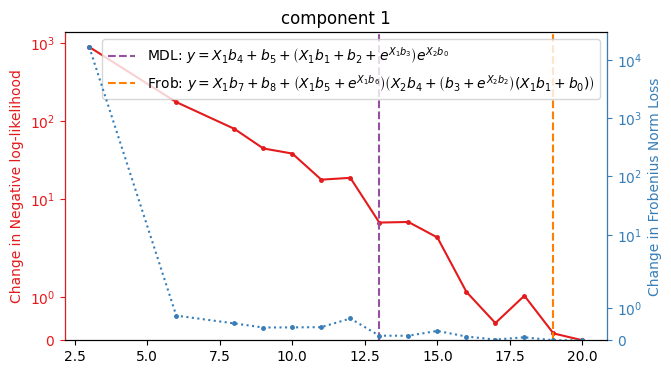

analysing 2 of 2 components
601 equations below MSE threshold
Best equation: (((((-5.8841547966) * X1) + 29.6279239655) * exp((((-0.3840085864) * exp(((-0.2970394194) * X1))) + ((-0.2316993028) * X2)))) + (-69.9948959351))
Best frob loss equation: ((((0.7617760897 * X1) + 3.3714191914) * ((0.1171111837 + exp(((-0.4993211031) * X2))) * (exp(exp((((-0.0394405872) * X2) + (0.1071071550 * X1)))) + ((-1.4215431213) * X1)))) + ((-59.0232086182) + ((-1.2505612373) * X2)))


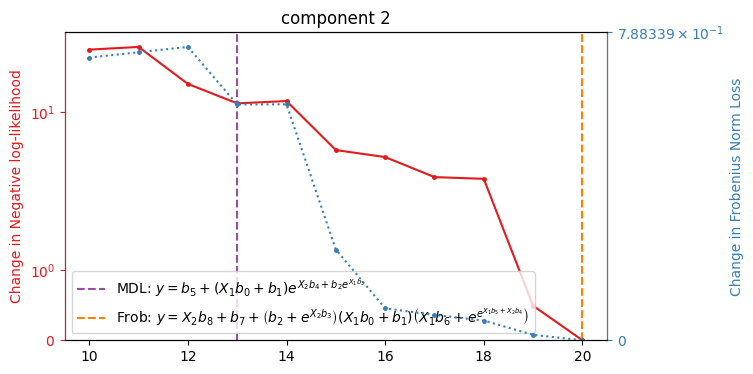

In [29]:


mdl_coordinates = []
frob_coordinates = []
mse_threshold = 100
n_components = 2

both_comp_latex = []
both_comp_eqs = []
both_comp_frobloss = []
both_comp_logL = []
both_comp_DL = []

for idx in range(n_components):

    
    print("analysing %d of %d components"%(idx+1, n_components))

    outdir = parent_dir + "component_%d/"%(idx + 1)
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")
    #data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")[:]
 
    #mse_threshold = mse_thresholds[idx]
    loss = np.array(data["mse"])
    #mse_threshold = np.inf

    mse_mask = (loss < mse_threshold)
    print("%d equations below MSE threshold"%(mse_mask.sum()))

    complexity = np.array(data["length"])[mse_mask]

    max_complexity = complexity.max()

    eqs = list(np.array(data['model'])[mse_mask])

    # chop some out to speed up code
    #eqs = eqs

    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_frobloss = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)

    for i, eq in tq(enumerate(eqs)):
        c, all_latex[i], all_logL[i], all_DL[i], all_frobloss[i] = compute_DL(eq, idx)

    # set nans to infs
    all_DL[np.isnan(all_DL)] = np.inf
    all_logL[np.isnan(all_logL)] = np.inf
    all_frobloss[np.isnan(all_frobloss)] = np.inf



    # Only changes in DL and logL matter
    #all_DL -= np.amin(all_DL)
    #all_logL -= np.amin(all_logL)

    # unique complexities
    # complexity = np.sort(np.unique(complexity))[1:] # remove comp=1 e.g. constants


    # get best DL model at given complexity
    pareto_DL = []
    pareto_logL = [] 
    pareto_latex = []
    pareto_eqs = []
    pareto_frobloss = []
    comps = []
    for comp in np.unique(complexity):
        if comp > 1:
            mask = (complexity == comp)
            ibest_model_at_complexity = np.argmin(all_DL[mask])
            pareto_DL.append(all_DL[mask][ibest_model_at_complexity])
            pareto_logL.append(all_logL[mask][ibest_model_at_complexity])
            pareto_frobloss.append(all_frobloss[mask][ibest_model_at_complexity])
            pareto_latex.append(np.array(all_latex)[mask][ibest_model_at_complexity])
            pareto_eqs.append(np.array(eqs)[mask][ibest_model_at_complexity])
            comps.append(comp)

    # redfine kept complexities
    complexity = np.array(comps)

    pareto_DL = np.array(pareto_DL)
    pareto_DL -= np.amin(pareto_DL)

    pareto_logL = np.array(pareto_logL)
    pareto_logL -= np.amin(pareto_logL)

    pareto_frobloss = np.array(pareto_frobloss)
    pareto_frobloss -= np.amin(pareto_frobloss)

    # store the latex and eq
    both_comp_latex.append(pareto_latex)
    both_comp_eqs.append(pareto_eqs)
    both_comp_frobloss.append(pareto_frobloss)
    both_comp_DL.append(pareto_DL)
    both_comp_logL.append(pareto_logL)

    # Print the best found equation
    ibest = np.argmin(pareto_DL)
    print('Best equation:', pareto_eqs[ibest])
    mdl_coordinates.append(pareto_eqs[ibest])

    # Print the best frob loss equation
    ibest_frob = np.argmin(pareto_frobloss)
    print('Best frob loss equation:', pareto_eqs[ibest_frob])
    frob_coordinates.append(pareto_eqs[ibest_frob])


    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    
    #ax1.plot(complexity, pareto_DL, marker='.', color=cm(0), markersize=5, )
    # ax2.plot(complexity, pareto_logL, marker='.', color=cm(1), markersize=5, ls=':')
    ax1.plot(complexity, pareto_logL, marker='.', color=cm(0), markersize=5, )
    ax2.plot(complexity, pareto_frobloss, marker='.', color=cm(1), markersize=5, ls=':')


    # ax1.set_ylabel('Change in Description Length')
    # ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.set_ylabel('Change in Negative log-likelihood')
    ax2.set_ylabel('Change in Frobenius Norm Loss')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))

    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))

    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)

    #ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%pareto_latex[ibest])
    ax1.axvline(complexity[ibest_frob], color=cm(4), ls='--', label=r'Frob: $y = %s$'%pareto_latex[ibest_frob])

    ax1.legend()
    plt.title("component %d"%(idx + 1))
    plt.show()
    #fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [30]:
idx = 0
outdir = parent_dir + "component_%d/"%(idx + 1)
# Find what description length (arXiv:2211.11461, Eq. 6) gives
data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")
#data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")[:]



#mse_threshold = mse_thresholds[idx]
loss = np.array(data["mse"])
#mse_threshold = np.inf

mse_mask = (loss < mse_threshold)
print("%d equations below MSE threshold"%(mse_mask.sum()))

complexity = np.array(data["length"])[mse_mask]

np.unique(np.unique(complexity))[1:]

633 equations below MSE threshold


array([ 3,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [31]:
all_DL[mask][ibest_model_at_complexity]

In [32]:
both_comp_eqs[0]

['(74.2366104126 + ((-2.0059099197) * X1))',
 '(74.2505493164 + (log(abs(((-0.0836777687) * X2))) * (1.4798393250 * X1)))',
 '(76.1907958984 + (log(abs((0.0845993161 * X2))) * (1.4486377239 + (1.4688177109 * X1))))',
 'exp(((log(abs(((-0.0883190930) * X2))) * (0.0254577529 + (0.0210011248 * X1))) + 4.3372912407))',
 '((exp((((-0.0441124924) * X1) + ((-0.2826188505) * X2))) * (((-5.1462392807) * X1) + (-6.5187735558))) + 76.1994934082)',
 '(76.1905288696 + (exp(((-0.2851298451) * X2)) * (((-7.5425324440) + ((-6.0603322983) * X1)) + exp((0.5499165654 * X1)))))',
 '(76.1959075928 + (exp(((-0.2847672999) * X2)) * (((-9.0923004150) + ((-6.0543313026) * X1)) + exp(exp((0.2111745775 * X1))))))',
 '((exp(((-0.4308077097) * X2)) * ((((-6.0041565895) * X1) + (-7.9225702286)) + exp((0.5961265564 * X1)))) + (((-0.7109474540) * X1) + 75.5530014038))',
 '((exp(4.3252019882) + (exp(((-0.4308096468) * X2)) * (((-7.9225363731) + ((-6.0874629021) * X1)) + exp((0.5961316228 * X1))))) + ((-0.6906504035) *

In [33]:
len(both_comp_eqs)

In [34]:
frob_coordinates

['((((((-7.1419906616) + (0.9296913147 * X1)) * (exp(((-0.4938113987) * X2)) + (-0.0285445005))) + (0.0708934292 * X2)) * ((1.2440547943 * X1) + exp(((-0.3120054901) * X1)))) + (((-1.3098195791) * X1) + 74.7289123535))',
 '((((0.7617760897 * X1) + 3.3714191914) * ((0.1171111837 + exp(((-0.4993211031) * X2))) * (exp(exp((((-0.0394405872) * X2) + (0.1071071550 * X1)))) + ((-1.4215431213) * X1)))) + ((-59.0232086182) + ((-1.2505612373) * X2)))']

In [35]:
both_comp_logL, both_comp_frobloss

([array([8.83718766e+02, 1.73827516e+02, 7.90676433e+01, 4.43075878e+01,
         3.81092426e+01, 1.76488201e+01, 1.86309368e+01, 4.98111933e+00,
         5.06860226e+00, 3.21113652e+00, 1.11705011e+00, 3.97045314e-01,
         1.02748829e+00, 1.58878624e-01, 0.00000000e+00]),
  array([31.4825207 , 33.07127345, 16.82167208, 11.78573   , 12.2948786 ,
          5.01660311,  4.41448367,  3.06103671,  2.96541893,  0.49373829,
          0.        ])],
 [array([1.65894033e+04, 7.61296913e-01, 5.20339355e-01, 3.94053236e-01,
         3.97792116e-01, 4.05256912e-01, 6.72425196e-01, 1.41475290e-01,
         1.40278041e-01, 2.88933173e-01, 1.15560949e-01, 2.18375996e-02,
         9.25373435e-02, 0.00000000e+00, 2.25898623e-03]),
  array([0.72363319, 0.7372063 , 0.75079919, 0.60363074, 0.60378762,
         0.23225869, 0.08178622, 0.06486131, 0.05050489, 0.01386219,
         0.        ])])

In [484]:
from sympy import init_printing
init_printing()
both_comp_latex[1]


def output_latex_table(idx, headers=False):
    to_print = ["$" + q + "$" for q in both_comp_latex[idx]]
    outs = ""

    if headers:
        outs += "\\textbf{COMPONENT %d}\n \n"%(idx+1) + "\\begin{tabular}{l|l} log loss & Equation \\\ \n \\hline \n"

    for i,t in enumerate(to_print):
        outs += "%.2f"%(both_comp_logL[idx][i]) + " & " +  t + " \\\ \n"

    if headers:
        outs += "\n\\end{tabular}" + "\n \\newpage"

    return outs


outs1 = output_latex_table(0, True)
outs2 = output_latex_table(1, True)


print(outs1)
print(outs2)


\textbf{COMPONENT 1}
 
\begin{tabular}{l|l} log loss & Equation \\ 
 \hline 
883.72 & $X_{1} b_{1} + b_{0}$ \\ 
173.83 & $X_{1} b_{2} \log{\left(\left|{X_{2} b_{1}}\right| \right)} + b_{0}$ \\ 
79.07 & $b_{0} + \left(X_{1} b_{3} + b_{2}\right) \log{\left(\left|{X_{2} b_{1}}\right| \right)}$ \\ 
44.31 & $e^{b_{3} + \left(X_{1} b_{2} + b_{1}\right) \log{\left(\left|{X_{2} b_{0}}\right| \right)}}$ \\ 
38.11 & $b_{4} + \left(X_{1} b_{2} + b_{3}\right) e^{X_{1} b_{0} + X_{2} b_{1}}$ \\ 
17.65 & $b_{0} + \left(X_{1} b_{3} + b_{2} + e^{X_{1} b_{4}}\right) e^{X_{2} b_{1}}$ \\ 
18.63 & $b_{0} + \left(X_{1} b_{3} + b_{2} + e^{e^{X_{1} b_{4}}}\right) e^{X_{2} b_{1}}$ \\ 
4.98 & $X_{1} b_{4} + b_{5} + \left(X_{1} b_{1} + b_{2} + e^{X_{1} b_{3}}\right) e^{X_{2} b_{0}}$ \\ 
5.07 & $X_{1} b_{5} + \left(X_{1} b_{3} + b_{2} + e^{X_{1} b_{4}}\right) e^{X_{2} b_{1}} + e^{b_{0}}$ \\ 
3.21 & $b_{0} + \left(b_{4} + \left(X_{1} b_{2} + b_{1}\right) e^{X_{2} b_{3}}\right) \left(X_{1} b_{5} + e^{X_{1} b_{6}}\r

In [485]:
from sympy import init_printing
init_printing()
both_comp_latex[1]


def output_latex_table(idx, headers=False):
    to_print = ["$" + q + "$" for q in both_comp_latex[idx]]
    outs = ""

    if headers:
        outs += "\\textbf{COMPONENT %d}\n \n"%(idx+1) + "\\begin{tabular}{l|l} \nFrob loss & Equation \\\ \n \\hline \n"

    for i,t in enumerate(to_print):
        outs += "%.2f"%(both_comp_frobloss[idx][i]) + " & " +  t + " \\\ \n"

    if headers:
        outs += "\n\\end{tabular}" + "\n \\newpage"

    return outs


outs1 = output_latex_table(0, True)
outs2 = output_latex_table(1, True)


print(outs1)
print(outs2)


\textbf{COMPONENT 1}
 
\begin{tabular}{l|l} 
Frob loss & Equation \\ 
 \hline 
16589.40 & $X_{1} b_{1} + b_{0}$ \\ 
0.76 & $X_{1} b_{2} \log{\left(\left|{X_{2} b_{1}}\right| \right)} + b_{0}$ \\ 
0.52 & $b_{0} + \left(X_{1} b_{3} + b_{2}\right) \log{\left(\left|{X_{2} b_{1}}\right| \right)}$ \\ 
0.39 & $e^{b_{3} + \left(X_{1} b_{2} + b_{1}\right) \log{\left(\left|{X_{2} b_{0}}\right| \right)}}$ \\ 
0.40 & $b_{4} + \left(X_{1} b_{2} + b_{3}\right) e^{X_{1} b_{0} + X_{2} b_{1}}$ \\ 
0.41 & $b_{0} + \left(X_{1} b_{3} + b_{2} + e^{X_{1} b_{4}}\right) e^{X_{2} b_{1}}$ \\ 
0.67 & $b_{0} + \left(X_{1} b_{3} + b_{2} + e^{e^{X_{1} b_{4}}}\right) e^{X_{2} b_{1}}$ \\ 
0.14 & $X_{1} b_{4} + b_{5} + \left(X_{1} b_{1} + b_{2} + e^{X_{1} b_{3}}\right) e^{X_{2} b_{0}}$ \\ 
0.14 & $X_{1} b_{5} + \left(X_{1} b_{3} + b_{2} + e^{X_{1} b_{4}}\right) e^{X_{2} b_{1}} + e^{b_{0}}$ \\ 
0.29 & $b_{0} + \left(b_{4} + \left(X_{1} b_{2} + b_{1}\right) e^{X_{2} b_{3}}\right) \left(X_{1} b_{5} + e^{X_{1} b_{6}}\righ

In [486]:
Fs

array([[[ 1.1430798 , -0.16893156],
        [-0.16893156,  5.2266684 ]],

       [[ 1.1822758 , -0.16240112],
        [-0.16240112,  5.53072   ]],

       [[ 2.2390702 , -0.20160274],
        [-0.20160274,  2.4737544 ]],

       ...,

       [[31.392336  ,  0.49826732],
        [ 0.49826732, 18.853405  ]],

       [[34.747017  , -0.41590577],
        [-0.41590577, 21.877455  ]],

       [[ 8.851296  ,  0.2718984 ],
        [ 0.2718984 ,  7.2493443 ]]], dtype=float32)

In [487]:
def check_flattening(coordinates, get_frob=False, Fs=Fs):

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "acosh", "asinh", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))

    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs": logAbs
                }
    
    
    jac_rows = []
    
    for eq in coordinates:
        expr, pars = replace_floats(eq)
        expr, nodes, c = esr.generation.generator.string_to_node(
            expr, 
            basis_functions, 
            evalf=True, 
            allow_eval=True, 
            check_ops=True, 
            locs=sympy_locs
        )
        param_list = [f"b{i}" for i in range(len(pars))]
        labels = nodes.to_list(basis_functions)
        latex_expr = sympy.latex(expr)
        
        # klog(n) + \sum_i log |c_i|
        aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
        
        # Turn function into callable object
        all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
        all_x = list(sympy.symbols(all_x, real=True))
        all_b = list(sympy.symbols(param_list, real=True))
        eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])



        def get_jac_row(p):
            
            myeq = lambda *args: eq_jax(*p, *args)

            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred
        

        jac_rows.append(get_jac_row(pars))

    Jpred = jnp.stack(jac_rows, axis=-1).transpose((0, 2, 1))
    print(Jpred.shape)
    #print(jnp.array(jac_rows).shape)
    #Jpred = jnp.stack(jac_rows, axis=-1)

    def flatten_fisher(J, F):
        invJ = jnp.linalg.inv(J)
        
        return invJ @ F @ invJ.T
    

    flats = jax.vmap(flatten_fisher)(Jpred, Fs)
    

    fn = lambda q: norm((q - jnp.eye(2))) + norm((jnp.linalg.pinv(q) - jnp.eye(2)))

    if get_frob:
        return flats, jnp.mean(jax.vmap(fn)(flats))

    else:
        return flats

        

In [488]:
# insert Deaglan's and Ben's coordinates

ad_hoc_coordinates = ['X1 * (1. / sqrt(X2)) * sqrt(50.)', 'log(X2) * sqrt(50.)']

# now geodesic normal coordinates

theta_star = np.array([0.0, 1.0])

def get_geo_coordinates(X, theta_star=theta_star):
    x1, x2 = X

    mu = x1
    sg = x2

    sg_star = (theta_star[1])
    mu_star = theta_star[0]
    
    beta = jnp.arcsinh( 
        ((1./(2. * sg_star * sg)) ) \
                * ((0.5 * (mu - mu_star)**2 + (sg - sg_star)**2)
                       * (0.5 * (mu - mu_star)**2 + (sg + sg_star)**2))**0.5
    )

    eta = jnp.where((mu == mu_star), jnp.sqrt(2.0) * beta * jnp.sign(0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2),
                   0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2 \
                      * jnp.sign(0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2)
    ) # \eta

    # y1 = 0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2 \
    #                  * jnp.sign(0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2)
    
    xi = jnp.where((mu == mu_star), 0.0, 
                   sg_star * (mu - mu_star) * jnp.sqrt(2.0) * jnp.sign(mu - mu_star)
    ) # \xi

    # y2 = sg_star * (mu - mu_star) * jnp.sqrt(2.0) * jnp.sign(mu - mu_star)

    return jnp.array([xi, eta]) #/ jnp.sqrt(50.)



def get_beta(X, theta_star=theta_star, return_beta=False):

    x1,x2 = X
    mu = x1
    sg = x2

    sg_star = (theta_star[1])
    mu_star = theta_star[0]
    
    beta = jnp.arcsinh( 
        ((1./(2. * sg_star * sg)) ) \
                * ((0.5 * (mu - mu_star)**2 + (sg - sg_star)**2)
                       * (0.5 * (mu - mu_star)**2 + (sg + sg_star)**2))**0.5

    )
    if return_beta:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0, beta
    else:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0  #(1./3.) * beta**2


geo_coordinates = ['0.5 * (X1 - 0.)^2 + X2 - 1.0', '1.0 * (X1 - 0.) * sqrt(2.)']


# geo_coordinates = [ '1.0 * (X1 - 0.) * sqrt(2.)', '0.5 * (X1 - 0.)^2 + X2 - 1.']


### code from Deaglan

In [489]:
sigma_star = 1.0
mu_star = 0.0

u_star = mu_star / sigma_star
v_star = jnp.sqrt(2)

def x_to_sinhbeta(x):
    sinh_beta = jnp.sqrt(
            (0.5 * (x[0] - mu_star)**2 + (x[1] - sigma_star)**2) *
            (0.5 * (x[0] - mu_star)**2 + (x[1] + sigma_star)**2)
        ) / x[1] / sigma_star / 2
    return sinh_beta


def xp_to_beta(xp):
    xi, eta = xp
    beta = jnp.sqrt(xi**2 + eta**2) / v_star
    return beta


def get_beta(X, return_beta=False):    
    xp = x_to_xprime(X)
    beta = xp_to_beta(xp)

    if return_beta:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0, beta
    else:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0  #(1./3.) * beta**2
    

def x_to_xprime(x):
    sinh_beta = x_to_sinhbeta(x)
    beta = jnp.arcsinh(sinh_beta)
    
    xi = jnp.where(jnp.abs(beta) > 1e-4,
                   beta * (x[0] - mu_star) / x[1] / sinh_beta,
                    0,
    )
    eta = jnp.where(jnp.abs(beta) > 1e-4,
                xi * (0.5 * (x[0] - mu_star)**2 + x[1] ** 2 - sigma_star**2) / 
                (sigma_star * (x[0] - mu_star) * jnp.sqrt(2)),
                0,
    )
    xprime = jnp.array([xi, eta])
    return xprime


def xprime_to_x(xp):

    beta = xp_to_beta(xp)
    xi, eta = xp
    u = jnp.where(beta == 0,
                   u_star,
                    (u_star + 
                        v_star * xi * jnp.sinh(beta) / 
                        (beta * v_star * jnp.cosh(beta) - eta * jnp.sinh(beta))
                    )
    )

    v = jnp.where(beta == 0,
                    v_star,
                    v_star * (
                        beta * v_star / 
                        (beta * v_star * jnp.cosh(beta) - eta * jnp.sinh(beta))
                    )
    )

    x = jnp.array([u * sigma_star, v * sigma_star / jnp.sqrt(2)])

    return x

def metric_fn(x):
    g = jnp.zeros((2, 2))
    g = g.at[0, 0].set(1 / x[1] ** 2)
    g = g.at[1, 1].set(2 / x[1] ** 2)
    return g


def transformed_metric(xp):
    x = xprime_to_x(xp)
    J = jax.jacfwd(x_to_xprime)(x)
    Jinv = jnp.linalg.inv(J)
    g = metric_fn(x)
    return Jinv.T @ g @ Jinv


def predicted_metric(xp):
    beta = xp_to_beta(xp)
    if beta == 0:
        return jnp.eye(2)
    xi, eta = xp
    g = jnp.zeros((2, 2))
    g = g.at[0, 0].set(eta**2 * jnp.sinh(beta)**2 + xi**2 * beta**2)
    g = g.at[0, 1].set(xi * eta * (beta ** 2 - jnp.sinh(beta)**2))
    g = g.at[1, 0].set(g[0, 1])
    g = g.at[1, 1].set(eta**2 * beta **2 + xi**2 * jnp.sinh(beta)**2)
    g = g / 2 / beta ** 4
    return g

In [490]:
jax.vmap(get_beta)(X).mean()

Array(1.6158518, dtype=float32)

In [491]:
jax.vmap(x_to_xprime)(X)

Array([[-0.22701362,  2.8323164 ],
       [-0.02799771,  2.7114086 ],
       [ 0.09658521,  2.2992465 ],
       ...,
       [ 1.8671615 ,  2.6137497 ],
       [-1.3819438 ,  1.1417886 ],
       [-0.87725985,  1.9455717 ]], dtype=float32)

In [492]:
jax.vmap(get_geo_coordinates)(X)

Array([[ 4.0127373, 50.06458  ],
       [ 0.4669702, 45.223232 ],
       [ 1.0339869, 24.614439 ],
       ...,
       [ 5.5942154,  7.8310738],
       [ 2.8808196,  2.3801885],
       [ 4.299931 ,  9.536312 ]], dtype=float32)

In [493]:
# create some true fishers everywhere


def true_fisher(X):
    n_d = 50
    mu = X[0]
    sig = (X[1])
    return n_d * jnp.array([[1./sig**2, 0.0],[0.0, 2. / sig**2]])


# def true_fisher(X):
#     n_d = 50
#     mu = X[0]
#     sig = jnp.sqrt(X[1])
#     return n_d * jnp.array([[1./sig**2, 0.0],[0.0, 1. / sig**4]])


true_fs = jax.vmap(true_fisher)(X)

In [494]:
true_fs

Array([[[ 1.0629464,  0.       ],
        [ 0.       ,  2.1258929]],

       [[ 1.0829844,  0.       ],
        [ 0.       ,  2.165969 ]],

       [[ 1.9726079,  0.       ],
        [ 0.       ,  3.9452157]],

       ...,

       [[49.639473 ,  0.       ],
        [ 0.       , 99.278946 ]],

       [[38.3022   ,  0.       ],
        [ 0.       , 76.6044   ]],

       [[ 8.454571 ,  0.       ],
        [ 0.       , 16.909142 ]]], dtype=float32)

In [495]:
# FUNCTIONS FOR CHECKING THE FLATNESS OF NEURAL AND NUMERICAL FNs

n_params = 2

frobenius_norm_loss = lambda q: norm((q - jnp.eye(n_params))) #+ norm((jnp.linalg.inv(q) - jnp.eye(n_params)))


def flatten_with_numerical_jacobian(J_eta, F):
    Jeta_inv = jnp.linalg.inv(J_eta)
    Q = Jeta_inv @ F @ Jeta_inv.T

    return Q

def check_neural_flattening(Js, Fs, get_frob=True):
    flats = jax.vmap(flatten_with_numerical_jacobian)(Js, Fs)

    if get_frob:
        return flats, jax.vmap(frobenius_norm_loss)(flats).mean()
    else:
        return flats


def flatten_with_fn(X, F, myfunc=get_geo_coordinates):    
    J_eta = jax.jacobian(myfunc)(X)
    Jeta_inv = jnp.linalg.inv(J_eta)

    Q = Jeta_inv.T @ F @ Jeta_inv # REVERSED THIS FOR ANALYTIC CONVENTION

    return Q

def check_numerical_fn_flattening(Xs, Fs, get_frob=True, myfunc=get_geo_coordinates):

    flatfn = lambda x,f: flatten_with_fn(x,f, myfunc=myfunc)
    flats = jax.vmap(flatfn)(Xs, Fs)

    if get_frob:
        return flats, jax.vmap(frobenius_norm_loss)(flats)
    else:
        return flats



def get_evalues(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    
    return eigenvalues[eigenvalues.argsort()]


In [496]:
nn_flats, nn_score = check_neural_flattening(dy, Fs)

geo2_flats, geo2_score = check_numerical_fn_flattening(X, Fs)


In [497]:
check_flattening(mdl_coordinates, True)[1], check_flattening(ad_hoc_coordinates, True)[1],  check_flattening(geo_coordinates, True)[1]

(2500, 2, 2)
(2500, 2, 2)
(2500, 2, 2)


(Array(1.5625951, dtype=float32),
 Array(5.853442, dtype=float32),
 Array(49.192257, dtype=float32))

In [498]:
mdl_coordinates

['((exp(((-0.4308077097) * X2)) * ((((-6.0041565895) * X1) + (-7.9225702286)) + exp((0.5961265564 * X1)))) + (((-0.7109474540) * X1) + 75.5530014038))',
 '(((((-5.8841547966) * X1) + 29.6279239655) * exp((((-0.3840085864) * exp(((-0.2970394194) * X1))) + ((-0.2316993028) * X2)))) + (-69.9948959351))']

In [499]:
n_d = 1
mdl_flats, mdl_score = check_flattening(mdl_coordinates, True)
frob_flats, frob_score = check_flattening(frob_coordinates, True)

adhoc_flats, adhoc_score = check_flattening(ad_hoc_coordinates, True)

geo_flats, geo_score = check_flattening(geo_coordinates, True)


# check neural network and numerical geodesic normal coord solution as well
nn_flats, nn_score = check_neural_flattening(dy, Fs)
geo2_flats, geo2_losses = check_numerical_fn_flattening(X, Fs / 50., myfunc=x_to_xprime)
geo2_score = geo2_losses.mean()

beta_geo_score = jax.vmap(get_beta)(X).mean()

print("\nchecking against neural fishers\n---")
print("neural network flattening score:", nn_score)
print("MDL SR flattening score:", mdl_score)
print("Frob SR flattening score:", frob_score)
print('ad-hoc flattening score:', adhoc_score)
# print('geo flattening score:', geo_score)
print('numerical geo flattening score:', geo2_score)
print('frob norm geo flattening score:', beta_geo_score)


(2500, 2, 2)
(2500, 2, 2)
(2500, 2, 2)
(2500, 2, 2)

checking against neural fishers
---
neural network flattening score: 0.37516844
MDL SR flattening score: 1.5625951
Frob SR flattening score: 0.84486485
ad-hoc flattening score: 5.853442
numerical geo flattening score: 1.5812179
frob norm geo flattening score: 1.6158518


In [500]:
# check on true fishers

n_d = 1
mdl_flats, mdl_score = check_flattening(mdl_coordinates, True, Fs=true_fs)
frob_flats, frob_score = check_flattening(frob_coordinates, True, Fs=true_fs)

adhoc_flats, adhoc_score = check_flattening(ad_hoc_coordinates, True, Fs=true_fs)

geo_flats, geo_score = check_flattening(geo_coordinates, True, Fs=true_fs)


# check neural network and numerical geodesic normal coord solution as well
nn_flats, nn_score = check_neural_flattening(dy, true_fs)
# 
geo2_flats, geo2_losses = check_numerical_fn_flattening(X, true_fs / 50, myfunc=x_to_xprime)
geo2_score = geo2_losses.mean()

print("\nchecking against true fishers\n---")
print("neural network flattening score:", nn_score)
print("MDL SR flattening score:", mdl_score)
print("Frob SR flattening score:", frob_score)
print('ad-hoc flattening score:', adhoc_score)
# print('geo flattening score:', geo_score)
print('numerical geo flattening score:', geo2_score)
print('frob norm geo flattening score:', beta_geo_score)



(2500, 2, 2)
(2500, 2, 2)
(2500, 2, 2)
(2500, 2, 2)

checking against true fishers
---
neural network flattening score: 1.9773283
MDL SR flattening score: 2.955271
Frob SR flattening score: 2.3402407
ad-hoc flattening score: 6.5948935
numerical geo flattening score: 1.6158516
frob norm geo flattening score: 1.6158518


In [501]:
true_fisher(jnp.array([1.5, 1.0]))

Array([[ 50.,   0.],
       [  0., 100.]], dtype=float32)

In [502]:
check_numerical_fn_flattening(jnp.array([[1.5, 1.0]]), true_fisher(jnp.array([1.5, 1.0]))[jnp.newaxis, :])


(Array([[[ 53.124996, -26.5165  ],
         [-26.5165  ,  24.999996]]], dtype=float32),
 Array([68.551186], dtype=float32))

In [503]:
mask_fid = ((np.abs(X[:, 0]) < 0.5) & (X[:, 1] < 2.0) & (X[:, 1] > 0.5))

In [504]:
mask_fid.sum()

65

(array([255., 266., 251., 253., 247., 230., 234., 271., 255., 238.]),
 array([0.40134698, 1.06119347, 1.72104001, 2.38088655, 3.0407331 ,
        3.70057964, 4.36042595, 5.02027273, 5.68011904, 6.33996582,
        6.99981213]),
 <BarContainer object of 10 artists>)

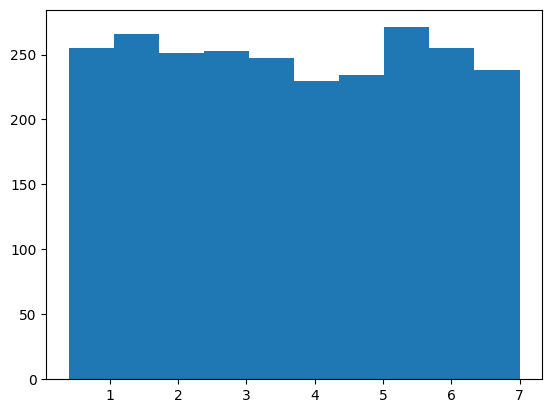

In [505]:
plt.hist(X[:, 1])

In [506]:
jax.vmap(get_beta)(X[mask_fid])

Array([0.15312123, 0.16597688, 0.05209744, 0.13377547, 0.06189275,
       0.13509965, 0.0228802 , 0.01509333, 0.01312721, 0.0100503 ,
       0.0980283 , 0.05548406, 0.05404842, 0.04655027, 0.01792586,
       0.06709766, 0.03501081, 0.01094317, 0.0120331 , 0.01851273,
       0.02531576, 0.08836627, 0.0604564 , 0.06246412, 0.12046385,
       0.04311907, 0.07032585, 0.12330639, 0.14097977, 0.0529815 ,
       0.16035104, 0.01502514, 0.1325624 , 0.01287532, 0.04595268,
       0.00040364, 0.0205251 , 0.07751274, 0.02340424, 0.00685585,
       0.03406549, 0.07664287, 0.02562165, 0.03266084, 0.03555441,
       0.00389326, 0.00042367, 0.04245341, 0.04456913, 0.16563773,
       0.04912066, 0.04800105, 0.03206134, 0.11600232, 0.02921784,
       0.103526  , 0.14921594, 0.17408264, 0.00883794, 0.03401363,
       0.03809702, 0.04934657, 0.02962506, 0.01220179, 0.01232588],      dtype=float32)

In [507]:
mu_star, sigma_star

In [508]:
# check around a fiducial point

# mask_fid = np.abs(X[:, 0]) < 0.5
# mask_fid = (np.abs(X[:, 1]) > 0.25) & (X[:, 1] < 1.25) & (X[:, 0] < 0.45) & (X[:, 0] > -0.5)

dff = X - jnp.array([mu_star, sigma_star])

mask_fid = (np.abs(dff)[:, 0] < 0.2) & (np.abs(dff)[:, 1] < 0.2)

print(mask_fid.sum())


# check neural network and numerical geodesic normal coord solution as well
_, nn_score_fid = check_neural_flattening(dy[mask_fid], Fs[mask_fid])
_, geo2_score_fid = check_numerical_fn_flattening(X[mask_fid], Fs[mask_fid] / 50, myfunc=x_to_xprime)

beta_geo_score = jax.vmap(get_beta)(X[mask_fid]).mean()


print("\nchecking against neural fishers\n---")

print("neural network flattening score near fiducial:", nn_score_fid)
print('numerical geo flattening score near fiducial:', geo2_score_fid.mean())
print('frob norm geo flattening score near fiducial:', beta_geo_score)

7

checking against neural fishers
---
neural network flattening score near fiducial: 0.48669517
numerical geo flattening score near fiducial: 0.82689196
frob norm geo flattening score near fiducial: 0.006876639


In [509]:
# check around a fiducial point

# mask_fid = np.abs(X[:, 0]) < 0.5
# mask_fid = (np.abs(X[:, 1]) > 0.25) & (X[:, 1] < 1.25) & (X[:, 0] < 0.45) & (X[:, 0] > -0.5)

# print(mask_fid.sum())


# check neural network and numerical geodesic normal coord solution as well
_, nn_score_fid = check_neural_flattening(dy[mask_fid], true_fs[mask_fid])
_, geo2_score_fid = check_numerical_fn_flattening(X[mask_fid], true_fs[mask_fid] / (50.), myfunc=x_to_xprime)

beta_geo_score = jax.vmap(get_beta)(X[mask_fid]).mean()


print("\nchecking against true fishers\n---")

print("neural network flattening score near fiducial:", nn_score_fid)
print('numerical geo flattening score near fiducial:', geo2_score_fid.mean())
print('frob norm geo flattening score near fiducial:', beta_geo_score)


checking against true fishers
---
neural network flattening score near fiducial: 4.8186016
numerical geo flattening score near fiducial: 0.0068767206
frob norm geo flattening score near fiducial: 0.006876639


(array([ 30.,  66., 130., 252., 490., 949., 467.,  67.,  30.,  19.]),
 array([0.03480142, 0.35106269, 0.66732395, 0.98358524, 1.29984653,
        1.61610782, 1.93236911, 2.24863029, 2.56489158, 2.88115287,
        3.19741416]),
 <BarContainer object of 10 artists>)

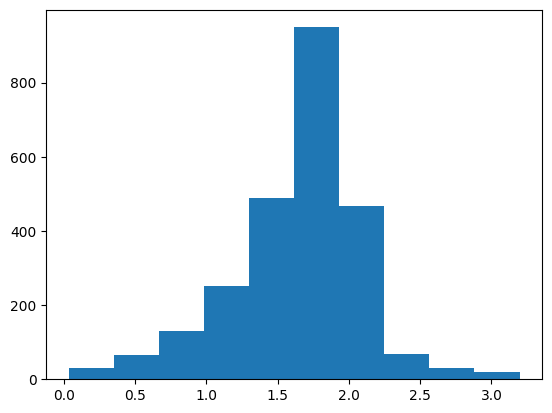

In [510]:
# check beta 

gb = lambda x: get_beta(x, return_beta=True)
_, betas = jax.vmap(gb)(X)
plt.hist(betas)

Text(0, 0.5, 'geo coordinate losses')

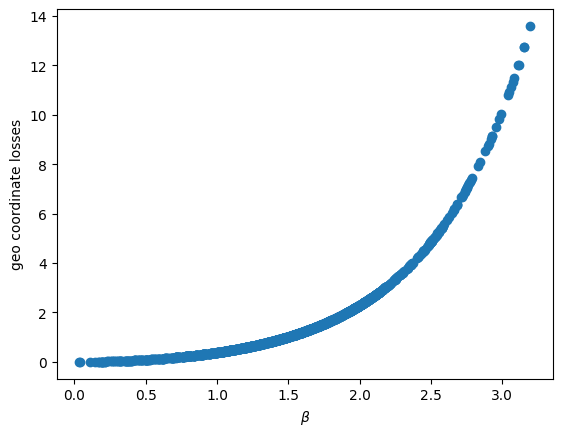

In [511]:
# check losses as fn of beta

plt.scatter(betas, geo2_losses)
plt.xlabel(r'$\beta$')
plt.ylabel(r'geo coordinate losses')

Text(0, 0.5, 'geo coordinate losses')

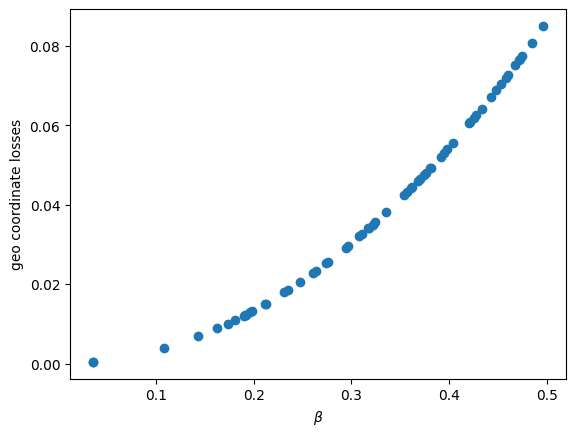

In [512]:
# check losses as fn of beta

plt.scatter(betas[betas < 0.5], geo2_losses[betas < 0.5])
plt.xlabel(r'$\beta$')
plt.ylabel(r'geo coordinate losses')

(array([2., 0., 0., 0., 1., 0., 0., 0., 2., 2.]),
 array([0.03480142, 0.05050385, 0.06620628, 0.08190872, 0.09761115,
        0.11331359, 0.12901603, 0.14471845, 0.16042089, 0.17612332,
        0.19182576]),
 <BarContainer object of 10 artists>)

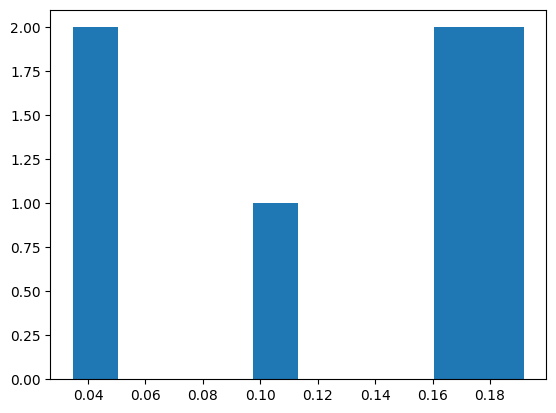

In [513]:
# check beta 
gb = lambda x: get_beta(x, return_beta=True)
_, betas = jax.vmap(gb)(X[mask_fid])
plt.hist(betas)

In [514]:
# check around a fiducial point with true fishers

# mask_fid = np.abs(X[:, 0]) < 0.5
# mask_fid = (np.abs(X[:, 1]) > 2.0) #& (X[:, 1] < 8.0) #& (X[:, 1] > 0.5)

# print(mask_fid.sum())


# check neural network and numerical geodesic normal coord solution as well
_, nn_score_fid = check_neural_flattening(dy[mask_fid], true_fs[mask_fid])
_, geo2_score_fid = check_numerical_fn_flattening(X[mask_fid], true_fs[mask_fid] / 50)

print("\nchecking against true fishers\n---")
print("neural network flattening score near fiducial:", nn_score_fid)
print('numerical geo flattening score near fiducial:', geo2_score_fid.mean())


checking against true fishers
---
neural network flattening score near fiducial: 4.8186016
numerical geo flattening score near fiducial: 0.5959208


In [515]:
# check the analytic new fishers:
ffn = lambda x: predicted_metric(x_to_xprime(x))
f_flat_analytic = jnp.array([ffn(x) for x in X])

analytic_g_losses = jax.vmap(frobenius_norm_loss)(f_flat_analytic)
print(analytic_g_losses.mean())

1.6158516


Text(0.5, 0, 'Frob loss for analytic g_flat')

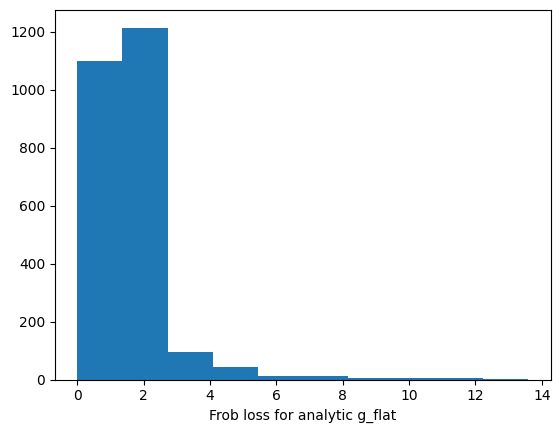

In [516]:
plt.hist(analytic_g_losses)
plt.xlabel('Frob loss for analytic g_flat')

In [517]:
# compare to beta score function

beta_geo_score_all = jax.vmap(get_beta)(X).mean()

print('analytic flattened Fisher score over prior:', analytic_g_losses.mean())
print('beta loss score over prior:', beta_geo_score_all)


analytic flattened Fisher score over prior: 1.6158516
beta loss score over prior: 1.6158518


In [518]:
# check neural network and numerical geodesic normal coord solution as well
_, nn_score_fid = check_neural_flattening(dy[mask_fid], true_fs[mask_fid])
# _, geo2_score_fid = check_numerical_fn_flattening(X[mask_fid], true_fs[mask_fid] / 50)



print("\nchecking against true fishers\n---")
print("neural network flattening score near fiducial:", nn_score_fid)
print('analytic flattened Fisher score near fiducial:', analytic_g_losses[mask_fid].mean())
print('frob norm geo flattening score near fiducial:', beta_geo_score)


checking against true fishers
---
neural network flattening score near fiducial: 4.8186016
analytic flattened Fisher score near fiducial: 0.0068765446
frob norm geo flattening score near fiducial: 0.006876639


### make a nice plot to compare teh flattening of neural and true Fishers

In [94]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [95]:
# compute e'values of flattened fishers

evalues_nn = jax.vmap(get_evalues)(nn_flats)
evalues_mdl = jax.vmap(get_evalues)(mdl_flats)
evalues_frob = jax.vmap(get_evalues)(frob_flats)

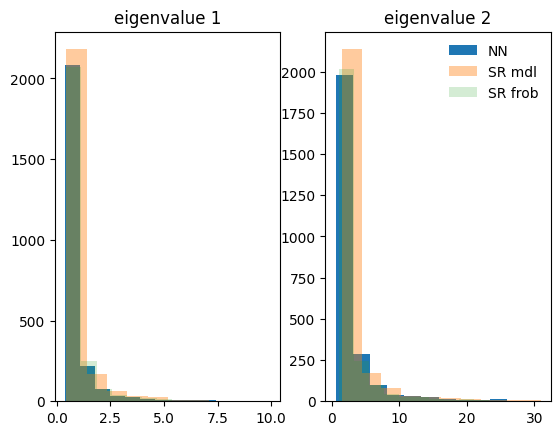

In [99]:
plt.subplot(121)
plt.title("eigenvalue 1")

plt.hist(evalues_nn[:, 0], label="NN")
plt.hist(evalues_mdl[:, 0], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 0], alpha=0.2, label="SR frob")


plt.subplot(122)
plt.title("eigenvalue 2")
plt.hist(evalues_nn[:, 1], label="NN")
plt.hist(evalues_mdl[:, 1], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 1], alpha=0.2, label="SR frob")


plt.legend(framealpha=0.0)

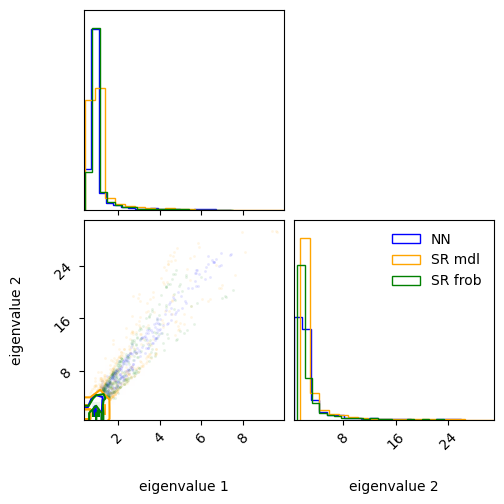

In [100]:
import corner

cols = ['eigenvalue 1', 'eigenvalue 2']

figure = corner.corner(np.array(evalues_nn), color="blue", labels=cols, hist_kwargs=dict(label="NN"))
figure = corner.corner(np.array(evalues_mdl), color="orange", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR mdl"))
figure = corner.corner(np.array(evalues_frob), color="green", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR frob"))

plt.legend(framealpha=0.0)


In [101]:
nn_flats

Array([[[ 1.035475  ,  0.00221516],
        [ 0.00221515,  1.1648501 ]],

       [[ 1.2611542 ,  0.07714981],
        [ 0.07714982,  1.3584484 ]],

       [[ 0.9869008 , -0.1374435 ],
        [-0.13744356,  1.0791707 ]],

       ...,

       [[ 1.1312267 ,  0.05065636],
        [ 0.05065635,  0.96722895]],

       [[ 1.4347227 , -0.01075012],
        [-0.0107501 ,  1.2318609 ]],

       [[ 0.9627056 , -0.05286645],
        [-0.0528665 ,  0.953844  ]]], dtype=float32)

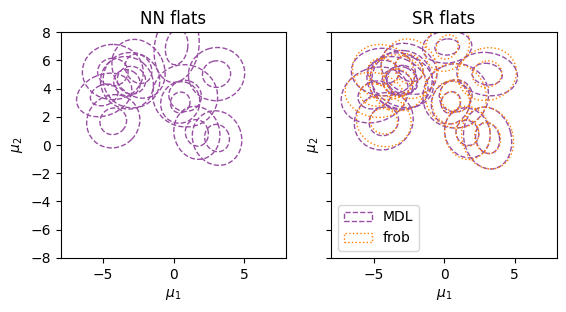

In [102]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 2, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")

ax.set_box_aspect(1)


plt.legend()

#plt.tight_layout()

In [103]:
datafile['norm_factor']

array(1.)

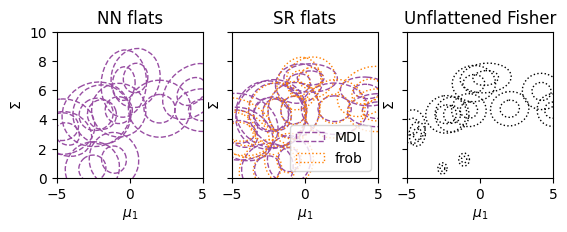

In [104]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 3, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("SR flats")


ax.set_box_aspect(1)




ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r],ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("Unflattened Fisher")
ax.set_box_aspect(1)



#plt.tight_layout()

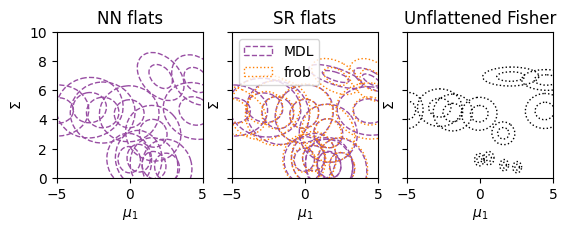

In [105]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 3, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("SR flats")


ax.set_box_aspect(1)




ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r],ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("Unflattened Fisher")
ax.set_box_aspect(1)



#plt.tight_layout()

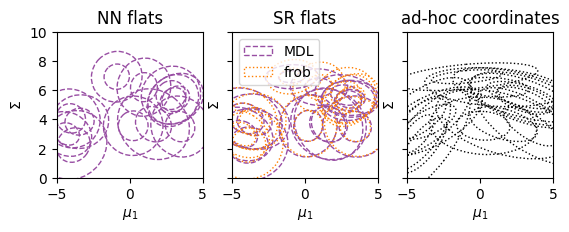

In [107]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 3, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("SR flats")


ax.set_box_aspect(1)




ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(adhoc_flats[r],ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(adhoc_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("ad-hoc coordinates")
ax.set_box_aspect(1)



#plt.tight_layout()

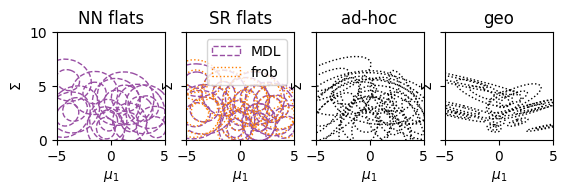

In [108]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 4, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("SR flats")


ax.set_box_aspect(1)


ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(adhoc_flats[r],ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(adhoc_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("ad-hoc")
ax.set_box_aspect(1)




ax = axs[3]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(geo_flats[r],ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(geo_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\Sigma$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 10)
ax.set_title("geo")
ax.set_box_aspect(1)



#plt.tight_layout()

In [71]:
datafile['norm_factor']

array(1.)

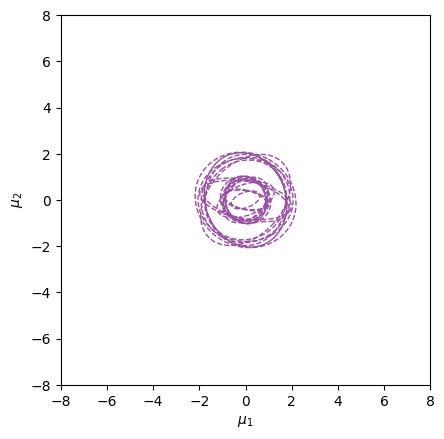

In [111]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8, 8)
ax.set_box_aspect(1)
#plt.legend()

In [112]:
Fs * 50

array([[[  57.153988,   -8.446578],
        [  -8.446578,  261.3334  ]],

       [[  59.11379 ,   -8.120056],
        [  -8.120056,  276.536   ]],

       [[ 111.95351 ,  -10.080137],
        [ -10.080137,  123.68772 ]],

       ...,

       [[1569.6168  ,   24.913366],
        [  24.913366,  942.6702  ]],

       [[1737.3508  ,  -20.795288],
        [ -20.795288, 1093.8727  ]],

       [[ 442.56482 ,   13.594919],
        [  13.594919,  362.46722 ]]], dtype=float32)

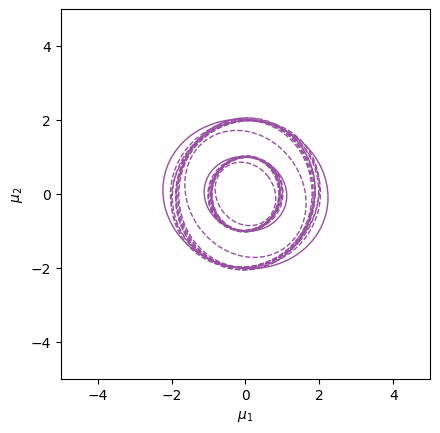

In [143]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()

In [ ]:
# plot a smattering of fishers

#randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r] * 50, mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5,5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()